In [1]:
import numpy as np
import pandas as pd
from sklearn import (model_selection, 
                     linear_model, 
                     discriminant_analysis, 
                     neighbors, 
                     tree, 
                     naive_bayes, 
                     metrics,
                     svm,
                     ensemble,
                     preprocessing)
import pickle
from matplotlib import pyplot
import itertools
import math
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')
import scripts

In [2]:
%matplotlib notebook
plotter=scripts.Tools()

In [3]:
from tqdm import tqdm_notebook

## Loading Flattened Image Data

In [4]:
inStream = open('flattened_image_RGB_data_metadata_10pct.pickle', 'rb')
imgData, metadata = pickle.load(inStream)
inStream.close()

## Some more image prep

In [5]:
imgData["gender"]=metadata["gender"]
imgData.shape

(16334, 10001)

In [6]:
total=len(imgData.index)
portionMale=len(imgData["gender"][imgData["gender"]==1].index)/total
portionFemale=len(imgData["gender"][imgData["gender"]==0].index)/total

In [7]:
print(str(round(portionMale,6)), str(round(portionFemale,6)))

0.493021 0.506979


In [8]:
my_features_Column_labels=imgData.columns[:-1]
my_target_Column_label="gender"

## Learning functions

In [9]:
def normalizeConfusionMatrix(confusionMatrix):
    normConfusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    return normConfusionMatrix

In [10]:
def train(df, featureColLabels, targetColLabel, model, train_size=0.5, 
          random_state=2,shuffle=False, return_all=False):
    fts = df[featureColLabels]
    features = fts.values

    tgs = df[targetColLabel]
    target = tgs.values 

    (features_train, features_test, target_train, target_test) = model_selection.train_test_split(
    features, target, train_size=train_size, random_state=random_state,shuffle=shuffle)

    trainedModel=model.fit(features_train, target_train)
    if return_all is True:
        return trainedModel, features_train, features_test, target_train, target_test
    elif return_all is False:
        return trainedModel, features_test, target_test
    else:
        return None

def test(features_test, target_test, trainedModel, normalize_cm=True):
    predictions = trainedModel.predict(features_test)
    accuracy=metrics.accuracy_score(target_test, predictions)
    confusionMatrix=metrics.confusion_matrix(target_test, predictions)
    precision=metrics.precision_score(target_test,predictions, average=None)
    if normalize_cm==True:
        # normalize the confusion matrix.
        confusionMatrix=normalizeConfusionMatrix(confusionMatrix)
    return (accuracy, precision, confusionMatrix)

In [11]:
def trainAndTest(df, featureColLabels, targetColLabel, model, train_size=0.5, 
                     random_state=2,shuffle=False, normalize_cm=True, return_all=False):
        '''
        ARGs:
            >> df: a pandas DataFrame of the dataset.
            >> featureColLabels: a list of strings that represents the colunm name of the features.
            >> targetColLabel: a string that represents the colunm name of the target.
            >> model: an sklearn model constructor.
        OPs:
            Trains and tests the dataset using the specified model.
        RETURN:
            >> If return_all is not a boolean: it returns None.
            >> If return_all is False: It returns the trained model (sklearn model), 
            the predictive accuracy of the test (numerical type),
            and the confusion matrix (numpy ndarray).
            >> If return_all is True: It returns the trained model (sklearn model), 
            the features training and test datasets (both numpy ndarrays), 
            the target training and test datasets (both numpy ndarrays),
            the predictive accuracy of the test (numerical type), and the 
            confusion matrix (numpy ndarray).
        '''
        trainedModel, features_train, features_test, target_train, target_test=train(df, featureColLabels=featureColLabels,
                                                        targetColLabel=targetColLabel,
                                                        model=model, train_size=train_size, 
                                                        random_state=random_state, shuffle=shuffle, return_all=True)
    
        (accuracy, precision, confusionMatrix)=test(features_test, target_test, trainedModel)
        
        if return_all is True:
            result = (trainedModel, features_train, features_test, target_train, 
                      target_test, accuracy, precision, confusionMatrix)
        elif return_all is False:
            result = (trainedModel, accuracy, precision, confusionMatrix)
        else:
            result = None
        return result

## Learning executions

In [12]:
lda=discriminant_analysis.LinearDiscriminantAnalysis(solver="svd", shrinkage=None, priors=None, 
                                                         n_components=None, store_covariance=False, tol=0.0001)

In [13]:
logit=linear_model.LogisticRegression(penalty="l2", dual=False, tol=0.0001, 
                                        C=1.0, fit_intercept=True, intercept_scaling=1, solver="saga", max_iter=100, 
                                        multi_class="ovr", verbose=0, warm_start=False, n_jobs=None)

In [14]:
k=int(math.sqrt(len(imgData.index)))
k=k if (not k%2) else k+1

knn=neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')

In [15]:
gnb=naive_bayes.GaussianNB(priors=None, var_smoothing=1e-09)

In [16]:
randForest=ensemble.RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=None, min_samples_split=2,
                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="auto", max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, 
                       n_jobs=None, random_state=2, verbose=0, warm_start=False, class_weight=None)

In [17]:
suppVM=svm.SVC(C=10, cache_size=500, class_weight="balanced", coef0=0,
  decision_function_shape='ovr', degree=2, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=2, shrinking=True,
  tol=0.9, verbose=False)

In [18]:
myModels = [suppVM]

In [19]:
finalData=imgData.sample(frac=1, random_state=5)

In [20]:
finalData.shape

(16334, 10001)

In [21]:
tModels=[]
for myModel in tqdm_notebook(myModels):
    (tModel, acc, p, cm)=trainAndTest(finalData, my_features_Column_labels, my_target_Column_label, model=myModel,
                                       train_size=0.9, random_state=2,shuffle=True, return_all=False, normalize_cm=True)
    tModels.append(tModel)
    modelName = type(tModel).__name__
    print(tModel)
    print(acc)
    print(p)
    
    Pl.plotVectorAndMatrix(p, cm, classes=["female", "male"],
                                     save=True,
                                     title = "10% Dataset "+modelName,
                                     timestampFilename = True)
    OtherPlotter.writeLogToFile("traditionalML.csv")

SVC(C=10, cache_size=500, class_weight='balanced', coef0=0,
  decision_function_shape='ovr', degree=2, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=2, shrinking=True, tol=0.9,
  verbose=False)
0.7337821297429621
[0.74285714 0.72496984]


NameError: name 'OtherPlotter' is not defined

<IPython.core.display.Javascript object>


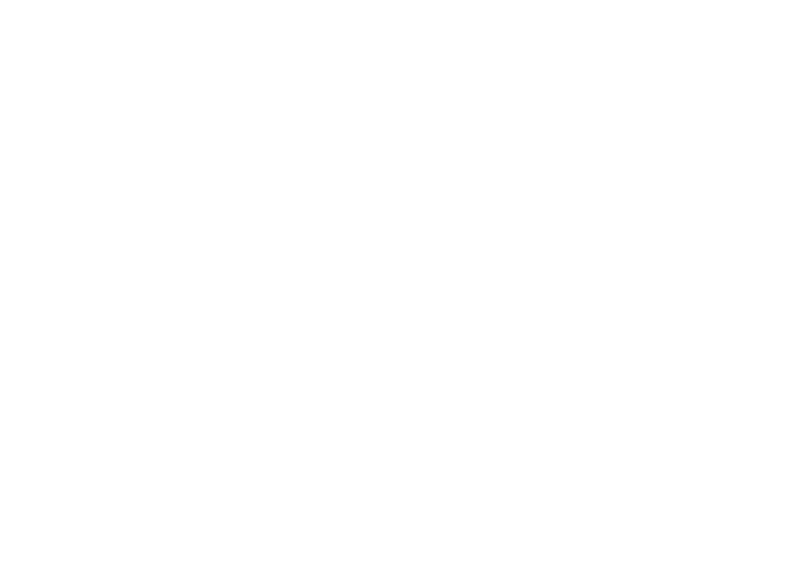

<IPython.core.display.Javascript object>


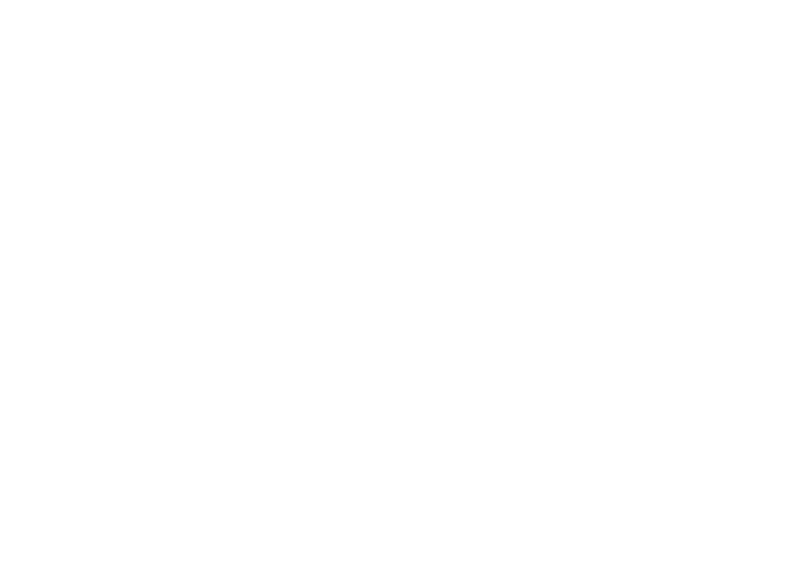

<IPython.core.display.Javascript object>


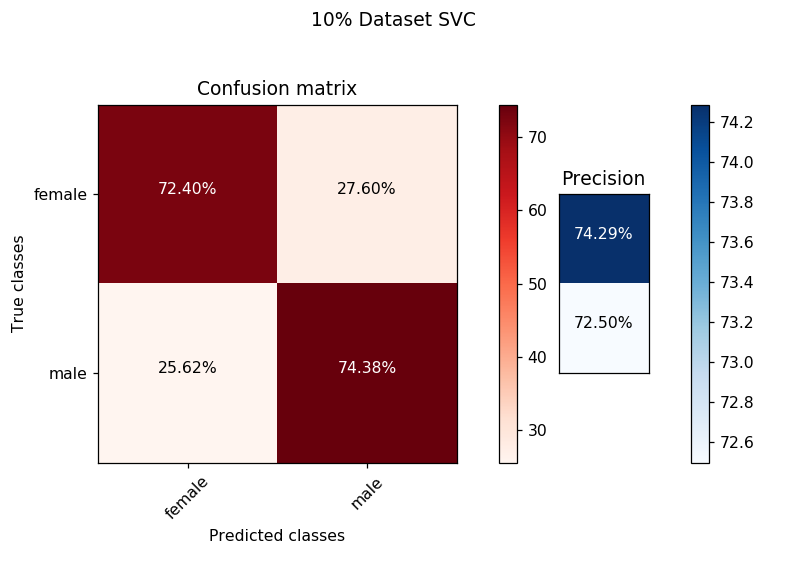

In [22]:
plotter.plotVectorAndMatrix(p, cm, classes=["female", "male"],
                                     save=True,
                                     title = "10% Dataset "+modelName,
                                     timestampFilename = True)
plotter.writeLogToFile("traditionalML.csv")

In [23]:
tModels

[SVC(C=10, cache_size=500, class_weight='balanced', coef0=0,
   decision_function_shape='ovr', degree=2, gamma=0.0005, kernel='rbf',
   max_iter=-1, probability=False, random_state=2, shrinking=True, tol=0.9,
   verbose=False)]

In [24]:
acc

0.7337821297429621